# <a id='toc1_'></a>[AC209b · Milestone 4](#toc0_)
**Project 41, Group 66**  
Alia Lu · Hebe Chen · Luc Chen · Yushu Qiu · Zhilin Chen  

**Dataset:** Jigsaw Multilingual Toxic Comment Classification  


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast 
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.optim import AdamW 
from tqdm import tqdm
import torch
from sklearn.metrics import f1_score
from torch.utils.data import TensorDataset

2025-04-23 07:38:46.899113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-23 07:38:46.899164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-23 07:38:46.899810: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-23 07:38:46.904203: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Table of contents**<a id='toc0_'></a>    
- [AC209b · Milestone 4](#toc1_)    
  - [Problem Statement](#toc1_1_)    
  - [Comprehensive EDA Review](#toc1_2_)    
    - [Label Distribution](#toc1_2_1_)    
    - [Length Distribution](#toc1_2_2_)    
    - [Label Correlation Heatmap](#toc1_2_3_)    
    - [Feature Engineering Summary](#toc1_2_4_)    
    - [Top TF-IDF Features](#toc1_2_5_)    
    - [Top Words in Toxic vs. Non-Toxic Comments](#toc1_2_6_)    
  - [3 Model Choice & Justification](#toc1_3_)    
    - [Training Process](#toc1_3_1_)    
  - [Results Interpretation and Analysis](#toc1_4_)    
    - [Validation Set Performance Metrics](#toc1_4_1_)    
    - [Test Set Performance Metrics](#toc1_4_2_)    
  - [Final Model Pipeline Setup](#toc1_5_)    
    - [ XLMRoberta Validation Performance](#toc1_5_1_)    
    - [XLMRoberta Test Set Performance](#toc1_5_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Problem Statement](#toc0_)

Toxic comments on the internet pose serious challenges to online communities, making it important to detect and filter harmful language automatically. Our project focuses on building a system that can detect different types of toxicity, such as insults, threats, and hate speech, in user-generated comments. What makes this task particularly hard is that a single comment might contain multiple types of toxicity at once, and that some forms (like threats) are much rarer than others. Our goal is to create a model that can accurately identify these labels, even when they co-occur or appear in subtle way, which is very challenging.

We use the Jigsaw Multilingual Toxic Comment Classification dataset, which includes comments in multiple languages and assigns six binary toxicity labels to each. This makes our task a multilabel classification problem, each comment needs to be evaluated independently for each type of toxicity.

Our initial assumption was that toxic comments might be longer or more detailed, especially when someone gets angry or upset, and we expected threats or hateful speech to involve more words and emotional buildup than short, polite comments. However, EDA revealed that toxic comments are often shorter than non-toxic ones, contradicting our expectations. We also assumed toxicity labels would be mostly independent, but we discovered that "obscene" and "insult" often co-occur, suggesting overlap in semantics. This prompted us to think more critically about label relationships and consider models that treat them jointly rather than independently. These insights led us to prioritize handling class imbalance, manage short-text sparsity, and plan for modeling label correlations in future iterations.



## <a id='toc1_2_'></a>[Comprehensive EDA Review](#toc0_)

In [ ]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
test_labels = pd.read_csv('data/test_labels.csv')
test_labels.replace(-1, 0, inplace=True)
print(train_df.shape)
print(train_df.columns)
print(train_df.dtypes)
train_df.head()
# missingness
train_df.isnull().sum().sort_values(ascending=False)

(159571, 8)
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

### <a id='toc1_2_1_'></a>[Label Distribution](#toc0_)

We could see there is an extreme class imbalance present in the training data. The “toxic” label is by far the most common, with over 15,000 comments, followed by “obscene” and “insult.” In contrast, categories like “severe_toxic,” “identity_hate,” and especially “threat” have drastically fewer positive examples—less than a tenth of the most common labels

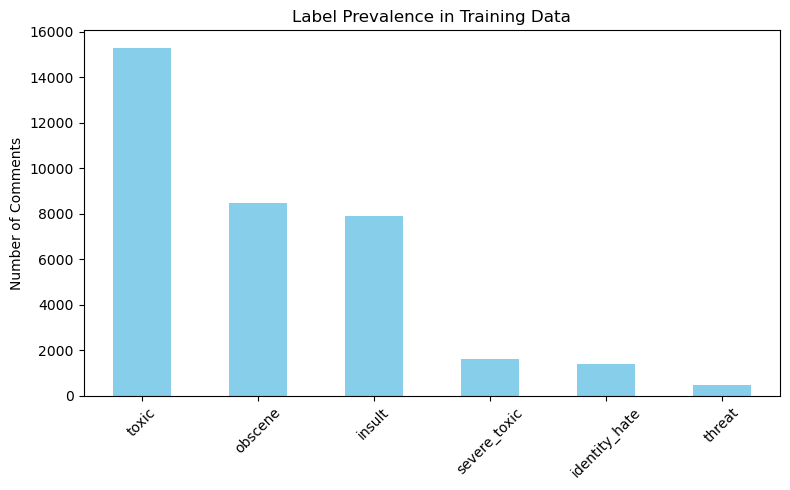

In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_counts = train_df[label_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(8,5))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Prevalence in Training Data')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### <a id='toc1_2_2_'></a>[Length Distribution](#toc0_)

The histogram shows a highly right skewed distribution of comment lengths, with the vast majority of comments containing fewer than 50 words. Its worth to highligh that the highest frequency is concentrated around the 10–20 word range, and the count drops off sharply as the length increases. While a small number of long comments exist (up to 500 words), they are extremely rare.

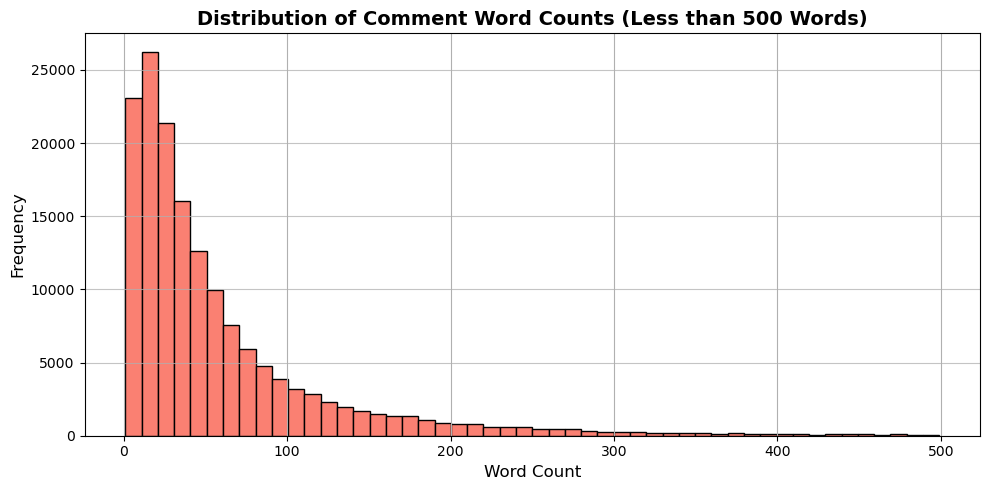

In [ ]:
#word count
train_df['word_count'] = train_df['comment_text'].apply(lambda x: len(str(x).split()))

# word count <500
plt.figure(figsize=(10, 5))
train_df[train_df['word_count'] < 500]['word_count'].hist(bins=50, color='salmon', edgecolor='black')
plt.title('Distribution of Comment Word Counts (Less than 500 Words)', fontsize=14, fontweight='bold')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


### <a id='toc1_2_3_'></a>[Label Correlation Heatmap](#toc0_)

This heatmap shows how different toxic behaviors are related. For example, "obscene" and "insult" are often found together, with a strong link of 0.74. "Toxic" is also linked to "insult" (0.65) and "obscene" (0.68), meaning these often go hand in hand with general toxicity. On the other hand, "threat" doesn't really connect much with the others (all ≤ 0.16), so it might need special attention. This means if we treat each label as totally separate, we might miss some important connections. By considering how these labels relate, like using multi-task learning or other smart methods, we could make our model better at spotting different kinds of toxic behavior that happen together.

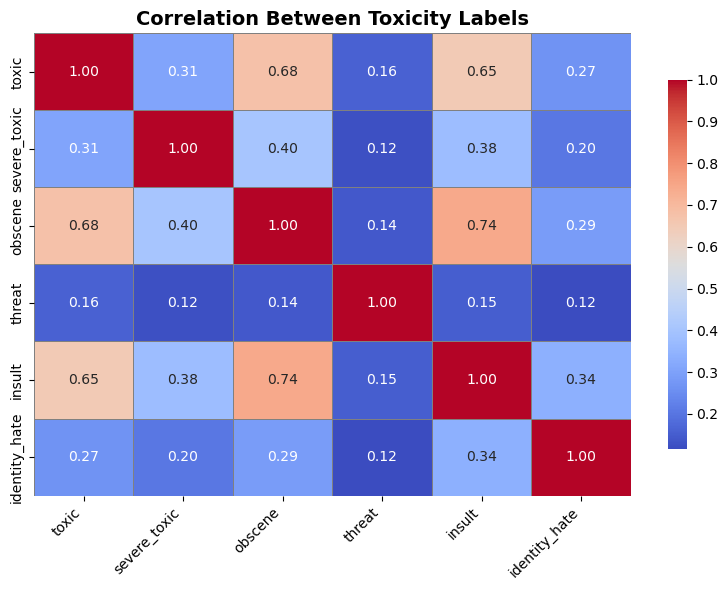

In [ ]:
corr = train_df[label_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='gray', cbar_kws={'shrink': 0.8})
plt.title('Correlation Between Toxicity Labels', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### <a id='toc1_2_4_'></a>[Feature Engineering Summary](#toc0_)

Before extracting features with TF-IDF, we applied basic text cleaning to remove HTML tags, punctuation, digits, and extra spaces. This reduces noise in the input and allows the model to focus on meaningful language patterns. The cleaned text is used for vectorization, while earlier EDA was performed on the raw text to preserve original structure (word count, character length).

In [ ]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # rm html tags
    text = re.sub(r'http\S+|www\S+', '', text)  # remove urls
    text = re.sub(r'\d+', '', text)  # rm digits
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)  # rm punctution
    text = re.sub(r'\s+', ' ', text).strip()  # rm extra whitespace ( )
    return text

### <a id='toc1_2_5_'></a>[Top TF-IDF Features](#toc0_)

The bar chart shows the top 20 words that pop up the most in our training data using TF-IDF. A lot of these words are not toxic and are related to Wikipedia, like "article," "page," "talk," "wikipedia," and nice words like "thank," "thanks," and "good."

This shows that TF-IDF often picks up on words that are used a lot, which might not help much in finding toxic stuff. For example, nice or discussion-related words might show up a lot, even if they don't really tell us about toxic behavior.

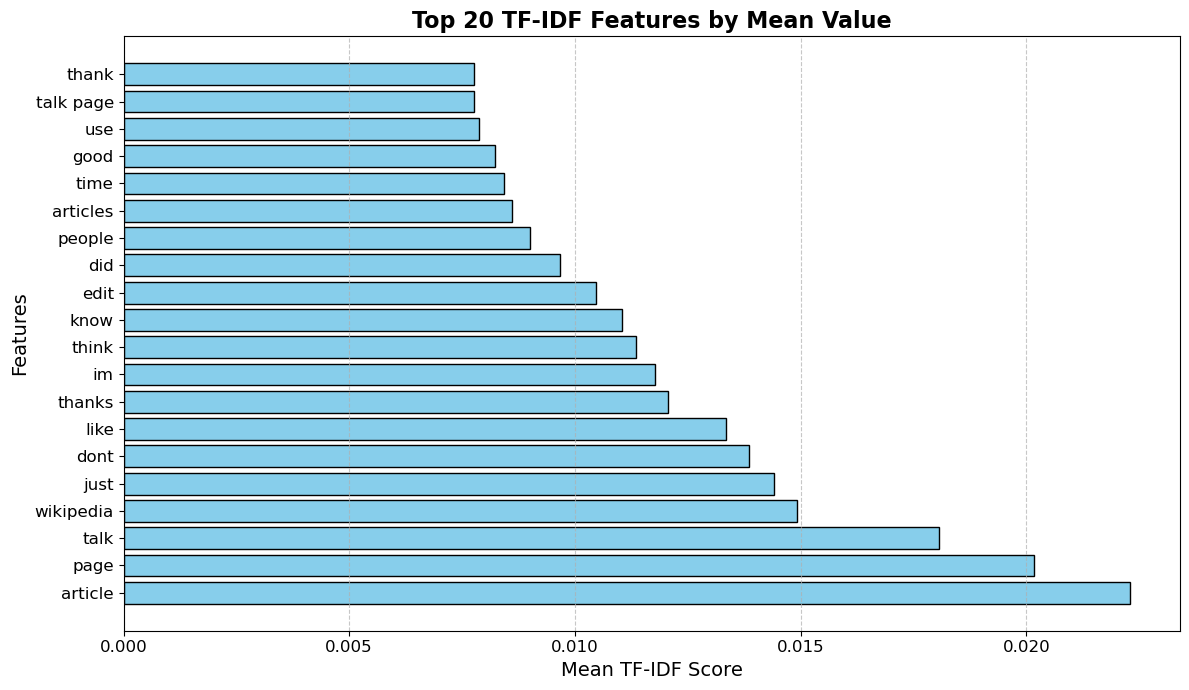

In [ ]:
train_df['cleaned_text'] = train_df['comment_text'].apply(clean_text)
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(train_df['cleaned_text'])
tfidf_means = np.asarray(X.mean(axis=0)).flatten()
top_indices = np.argsort(tfidf_means)[::-1][:20]
top_words = np.array(vectorizer.get_feature_names_out())[top_indices]

plt.figure(figsize=(12, 7))
plt.barh(top_words[::-1], tfidf_means[top_indices][::-1], color='skyblue', edgecolor='black')
plt.title("Top 20 TF-IDF Features by Mean Value", fontsize=16, fontweight='bold')
plt.xlabel("Mean TF-IDF Score", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

### <a id='toc1_2_6_'></a>[Top Words in Toxic vs. Non-Toxic Comments](#toc0_)

The bar charts below compare the top 15 most frequent words in toxic and non-toxic comments. As expected, many high-frequency words are shared (e.g., "you", "the", "and"), but toxic comments also contain more aggressive or explicit language such as "f*ck", "your", and "are" used in a hostile tone. Non-toxic comments, on the other hand, show more balanced and neutral vocabulary. This difference reinforces our decision to use TF-IDF as it captures word importance across documents, and supports the assumption that lexical patterns can help distinguish toxic content.

It also makes us take a step back to think about its limitations. Eventually it is bag-of-words based, ignoring context, word order, tone, or negation. For example, “you’re right” and “you’re trash” are treated similarly in terms of structure. It struggles with short texts, which dominate the dataset. Many comments are too brief to generate meaningful TF-IDF variation.


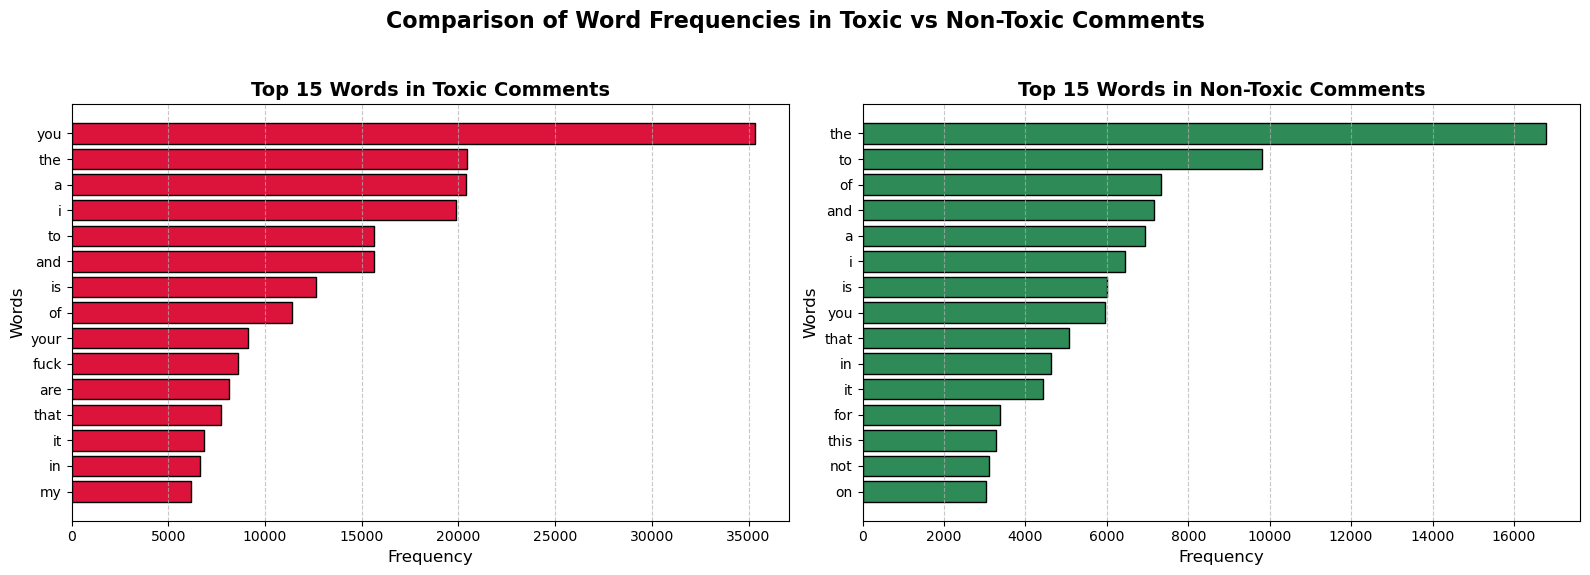

In [ ]:
toxic_words = ' '.join(train_df[train_df['toxic'] == 1]['cleaned_text']).split()
non_toxic_words = ' '.join(train_df[train_df['toxic'] == 0]['cleaned_text'].sample(5000)).split()

toxic_freq = Counter(toxic_words).most_common(15)
non_toxic_freq = Counter(non_toxic_words).most_common(15)
toxic_words, toxic_counts = zip(*toxic_freq)
non_toxic_words, non_toxic_counts = zip(*non_toxic_freq)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# toxic
axes[0].barh(toxic_words[::-1], toxic_counts[::-1], color='crimson', edgecolor='black')
axes[0].set_title('Top 15 Words in Toxic Comments', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_ylabel('Words', fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=10)
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

# not toxic words
axes[1].barh(non_toxic_words[::-1], non_toxic_counts[::-1], color='seagreen', edgecolor='black')
axes[1].set_title('Top 15 Words in Non-Toxic Comments', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_ylabel('Words', fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=10)
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

plt.suptitle('Comparison of Word Frequencies in Toxic vs Non-Toxic Comments', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## <a id='toc1_3_'></a>[3 Model Choice & Justification](#toc0_)

We chose the One-vs-Rest Logistic Regression as our baseline model for its simplicity, interpretability, and ability to effectively manage high dimensional sparse data, which is characteristics of TF-IDF representations. For our model, a separate binary logistic regression classifier is trained for each toxicity label. We believed Logistic regression can offer a relatively quick training and easy interpretability through coefficient analysis, making it an ideal initial step before advancing to more complex neural models.

For input features, we utilized TF-IDF vectorization on the cleaned comment texts, incorporating unigrams and bigrams (ngram_range=(1, 2)), with a vocabulary size limited to 10,000. We thought in this case the representation captures significant token frequency signals while maintaining computational efficiency. The dataset was divided into an 80/20 stratified training/validation split using the “toxic” label to preserve class distribution.

Training was conducted using scikit-learn’s OneVsRestClassifier wrapper with logistic regression (C=1.0, max_iter=1000) as the base estimator (We will further tune it in the future by incoporating grid search, for now we manually tune it and select the best params). We assessed model performance on both the validation and test sets using per-label precision, recall, F1-score, and AUC.

We presented our result and performance of our initial baseline model below, and further explanation and insight are provided for section 4





### <a id='toc1_3_1_'></a>[Training Process](#toc0_)

In [15]:
random_seed = 42

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

X = train_df['cleaned_text']
y = train_df[labels]

vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=random_seed, stratify=train_df['toxic']
)

clf = OneVsRestClassifier(LogisticRegression(C=1.0, max_iter=1000, random_state=random_seed))
clf.fit(X_train, y_train)


OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000,
                                                 random_state=42))

In [16]:
# eval on val set
y_val_pred = clf.predict(X_val)
y_val_probs = clf.predict_proba(X_val)

# eval each label
for i, label in enumerate(labels):
    print(f"\n {label.upper()} (Validation) ")
    report = classification_report(y_val[label], y_val_pred[:, i], digits=3, output_dict=True)
    print(classification_report(y_val[label], y_val_pred[:, i], digits=3))
    auc = roc_auc_score(y_val[label], y_val_probs[:, i])
    f1_score_val = report['1']['f1-score'] 
    print(f"AUC: {auc:.3f}")
    print(f"F1 Score: {f1_score_val:.3f}")


 TOXIC (Validation) 
              precision    recall  f1-score   support

           0      0.960     0.994     0.977     28856
           1      0.921     0.606     0.731      3059

    accuracy                          0.957     31915
   macro avg      0.940     0.800     0.854     31915
weighted avg      0.956     0.957     0.953     31915

AUC: 0.966
F1 Score: 0.731

 SEVERE_TOXIC (Validation) 
              precision    recall  f1-score   support

           0      0.993     0.999     0.996     31604
           1      0.612     0.238     0.343       311

    accuracy                          0.991     31915
   macro avg      0.802     0.618     0.669     31915
weighted avg      0.989     0.991     0.989     31915

AUC: 0.980
F1 Score: 0.343

 OBSCENE (Validation) 
              precision    recall  f1-score   support

           0      0.980     0.997     0.988     30205
           1      0.916     0.633     0.749      1710

    accuracy                          0.977     31915

| Category      | Precision | Recall | F1-Score | AUC   | Support | Class Imbalance |
|--------------|-----------|--------|----------|-------|---------|-----------------|
| Toxic        | 0.921     | 0.606  | 0.731    | 0.966 | 3,059   | 1:9.4          |
| Severe Toxic | 0.612     | 0.238  | 0.343    | 0.980 | 311     | 1:101.6        |
| Obscene      | 0.916     | 0.633  | 0.749    | 0.978 | 1,710   | 1:17.7         |
| Threat       | 0.583     | 0.072  | 0.128    | 0.976 | 97      | 1:328.0        |
| Insult       | 0.821     | 0.514  | 0.633    | 0.972 | 1,590   | 1:19.1         |
| Identity Hate| 0.733     | 0.190  | 0.302    | 0.979 | 289     | 1:109.4        |

In [17]:
test_df['cleaned_text'] = test_df['comment_text'].apply(clean_text)
X_test = vectorizer.transform(test_df['cleaned_text'])

y_test = test_labels[labels]
y_test_pred = clf.predict(X_test)
y_test_probs = clf.predict_proba(X_test)

for i, label in enumerate(labels):
    print(f"\n {label.upper()} (Test Set) ")
    report = classification_report(y_test[label], y_test_pred[:, i], digits=3, output_dict=True)
    print(classification_report(y_test[label], y_test_pred[:, i], digits=3))
    auc = roc_auc_score(y_test[label], y_test_probs[:, i])
    f1_score_test = report['1']['f1-score']  
    print(f"AUC: {auc:.3f}")
    print(f"F1 Score: {f1_score_test:.3f}")


 TOXIC (Test Set) 
              precision    recall  f1-score   support

           0      0.985     0.858     0.917    147074
           1      0.168     0.689     0.270      6090

    accuracy                          0.851    153164
   macro avg      0.576     0.774     0.593    153164
weighted avg      0.953     0.851     0.892    153164

AUC: 0.882
F1 Score: 0.270

 SEVERE_TOXIC (Test Set) 
              precision    recall  f1-score   support

           0      0.998     0.994     0.996    152797
           1      0.101     0.283     0.149       367

    accuracy                          0.992    153164
   macro avg      0.550     0.639     0.572    153164
weighted avg      0.996     0.992     0.994    153164

AUC: 0.967
F1 Score: 0.149

 OBSCENE (Test Set) 
              precision    recall  f1-score   support

           0      0.989     0.923     0.955    149473
           1      0.162     0.603     0.255      3691

    accuracy                          0.915    153164
   ma

| Category      | Precision | Recall | F1-Score | AUC   | Support | Class Imbalance |
|--------------|-----------|--------|----------|-------|---------|-----------------|
| Toxic        | 0.168     | 0.689  | 0.270    | 0.882 | 6,090   | 1:24.2         |
| Severe Toxic | 0.101     | 0.283  | 0.149    | 0.967 | 367     | 1:416.3        |
| Obscene      | 0.162     | 0.603  | 0.255    | 0.916 | 3,691   | 1:40.5         |
| Threat       | 0.176     | 0.166  | 0.171    | 0.974 | 211     | 1:724.9        |
| Insult       | 0.164     | 0.501  | 0.247    | 0.914 | 3,427   | 1:43.7         |
| Identity Hate| 0.182     | 0.240  | 0.207    | 0.958 | 712     | 1:214.1        |

## <a id='toc1_4_'></a>[Results Interpretation and Analysis](#toc0_)

### <a id='toc1_4_1_'></a>[Validation Set Performance Metrics](#toc0_)
| Category      | Precision | Recall | F1-Score | AUC   | Support | Class Imbalance |
|--------------|-----------|--------|----------|-------|---------|-----------------|
| Toxic        | 0.921     | 0.606  | 0.731    | 0.966 | 3,059   | 1:9.4          |
| Severe Toxic | 0.612     | 0.238  | 0.343    | 0.980 | 311     | 1:101.6        |
| Obscene      | 0.916     | 0.633  | 0.749    | 0.978 | 1,710   | 1:17.7         |
| Threat       | 0.583     | 0.072  | 0.128    | 0.976 | 97      | 1:328.0        |
| Insult       | 0.821     | 0.514  | 0.633    | 0.972 | 1,590   | 1:19.1         |
| Identity Hate| 0.733     | 0.190  | 0.302    | 0.979 | 289     | 1:109.4        |

### <a id='toc1_4_2_'></a>[Test Set Performance Metrics](#toc0_)
| Category      | Precision | Recall | F1-Score | AUC   | Support | Class Imbalance |
|--------------|-----------|--------|----------|-------|---------|-----------------|
| Toxic        | 0.168     | 0.689  | 0.270    | 0.882 | 6,090   | 1:24.2         |
| Severe Toxic | 0.101     | 0.283  | 0.149    | 0.967 | 367     | 1:416.3        |
| Obscene      | 0.162     | 0.603  | 0.255    | 0.916 | 3,691   | 1:40.5         |
| Threat       | 0.176     | 0.166  | 0.171    | 0.974 | 211     | 1:724.9        |
| Insult       | 0.164     | 0.501  | 0.247    | 0.914 | 3,427   | 1:43.7         |
| Identity Hate| 0.182     | 0.240  | 0.207    | 0.958 | 712     | 1:214.1        |

The baseline One-vs-Rest logistic regression model provides a strong starting point by achieving high recall and AUC on the validation set for common toxicity categories such as "toxic," "obscene," and "insult," indicating the model can detect most toxic instances and effectively rank samples by toxicity probability. However, on the unseen test set, we observed a significant drop in precision, even though recall remained relatively high. For example, the recall for the "toxic" label remained at 0.689, but precision dropped to 0.168, leading to a low F1-score of 0.270, and unfortuanatally pattern that occurred consistently across all categories. The model’s tendency to overpredict toxic labels suggests a misalignment between training/validation and test distributions (possibly due to dataset shift, label noise, or mismatch in lexical patterns across domains or languages). Since the test set includes multilingual data, whereas the training set is primarily in English, this gap likely reflects a lack of generalization to different linguistic or cultural expressions of toxicity. Moreover, the model struggles significantly on rare labels like "threat" and "identity_hate," where class imbalance is extreme (1:328 and 1:109 on validation), as the logistic regression model, combined with sparse TF-IDF features, is inherently limited in its ability to learn rare or context-dependent patterns, treating each word independently and lacking any notion of context, phrase structure, or sentence tone (all of which are critical in identifying more subtle forms of hate speech or implicit threats). So to improve performance, especially on the test set, future iterations should consider threshold tuning, setting different decision thresholds per label to balance precision-recall based on label rarity and business priority. Detailed suggestions on improve is provided for Section 5


## <a id='toc1_5_'></a>[Final Model Pipeline Setup](#toc0_)

We want to move ahead a bit to clarify the model use, so we include our final model below

So given the limitation of TF-IDF and logistic regression in capturing semantic context and handling cross-lingual nuances, we used XLM-Roberta, which is a multilingual transformer architecture fine tuned for multilabel toxicity classification. The pipeline begins with text preprocessing using a custom clean_text() function as we described above, followed by tokenization with the xlm-roberta-base tokenizer, truncating sequences at 256 tokens. 

We split the training data into 80% training and 20% validation using stratified sampling on the toxic label. A custom ToxicDataset class is defined to create PyTorch-compatible datasets. The model is initialized with XLMRobertaForSequenceClassification, configured with six output labels and a multi_label_classification problem type. Training uses the BCEWithLogitsLoss and AdamW optimizer with a learning rate of 2e-5 and batch size of 32 for three epochs (we are planning to increase the batch size based of the resource we have). At the end of each epoch, we compute training and validation loss, macro F1-score, and macro AUC. For validation predictions, we apply per-label threshold tuning, selecting the threshold between 0.1 and 0.9 that maximizes F1 for each label. We realized this step is fairly important because different toxicity categories exhibit varying prevalence and probability distributions. So when we were trying to use a fixed threshold like 0.5 across all labels and it underperformed, especially for rare labels like “threat” and “identity_hate.” By having the decision boundary for each label, we aim to achieve a more balanced precision-recall tradeoff. After training, we evaluate on the held-out test set using the best thresholds from validation, reporting per-label precision, recall, F1, and AUC. (But one open question we had is whether it is more appropriate to tune thresholds at the end of each epoch, as we currently do or only once after the final model is selected. We wonder if per-epoch tuning risks overfitting to the validation set, or whether it helps track the evolving behavior of the model during training).

Our model performs strongly on validation, with F1-scores above 0.75 for most categories and especially high scores for "toxic" and "obscene", outperfrom all categories compare to our baseline. However, performance drops on the test set, with high recall but low precision due to class imbalance and domain shift. 

In regards of future plan, we are considering try to fine-tuning of the pretrained model and exploring advanced techniques such as class-balanced loss, focal loss, or data augmentation. We are worry about the fine tuning is only giving minimal improvement and won't give us significant improved on performance (Given our current test performance is quite low), we would appreciate any suggestions on whether XLM-Roberta remains an appropriate architecture for this task, or if there are alternative models or training strategies you would recommend exploring. 


Given the task is fairly hard because the data is extremely imbalanced, with most comments not being toxic, and some categories having very rare cases, and some comments coexisting with multiple categories, the F1 score metric is naturally hard to improve. We are considering the threshold to pass through, especially if there is a strict requirement like needing to pass 50%.




### <a id='toc1_5_1_'></a>[ XLMRoberta Validation Performance](#toc0_)
 | Category      | Precision | Recall | F1-Score | AUC   | Support | Class Imbalance |
--------------|-----------|--------|----------|-------|---------|-----------------|
| Toxic        | 0.822     | 0.825  | 0.824    | 0.985 | 1,958   | 1:9.5           |
| Severe Toxic | 0.399     | 0.606  | 0.482    | 0.985 | 216     | 1:102.0         |
| Obscene      | 0.830     | 0.864  | 0.847    | 0.993 | 1,105   | 1:18.0          |
| Threat       | 0.322     | 0.619  | 0.424    | 0.988 | 63      | 1:330.0         |
| Insult       | 0.741     | 0.785  | 0.762    | 0.988 | 1,015   | 1:19.5          |
| Identity Hate| 0.509     | 0.646  | 0.569    | 0.985 | 181     | 1:110.0         |


### <a id='toc1_5_2_'></a>[XLMRoberta Test Set Performance](#toc0_)
| Category      | Precision | Recall | F1-Score | AUC   | Support | Class Imbalance |
|--------------|-----------|--------|----------|-------|---------|-----------------|
| TOXIC        | 0.153     | 0.899  | 0.262    | 0.897 | 6,090   | 1:24.1          |
| SEVERE_TOXIC | 0.070     | 0.755  | 0.128    | 0.979 | 367     | 1:416.5         |
| OBSCENE      | 0.142     | 0.815  | 0.243    | 0.929 | 3,691   | 1:40.5          |
| THREAT       | 0.107     | 0.687  | 0.185    | 0.981 | 211     | 1:724.9         |
| INSULT       | 0.147     | 0.751  | 0.247    | 0.931 | 3,427   | 1:43.7          |
| IDENTITY_HATE| 0.125     | 0.697  | 0.213    | 0.970 | 712     | 1:214.2         |





In [13]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

def tokenize_function(example):
    return tokenizer(
        example['cleaned_text'],
        padding='max_length',
        truncation=True,
        max_length=256,
        return_tensors='pt'
    )

class ToxicDataset(Dataset):
    def __init__(self, df):
        self.encodings = tokenizer(
            df['cleaned_text'].tolist(),
            padding='max_length',
            truncation=True,
            max_length=256,
            return_tensors='pt'
        )
        self.labels = torch.tensor(df[labels].values).float()

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

    def __len__(self):
        return len(self.labels)


In [16]:
train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df['toxic'], random_state=42
)

train_dataset = ToxicDataset(train_df)
val_dataset = ToxicDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = XLMRobertaForSequenceClassification.from_pretrained(
    'xlm-roberta-base',
    num_labels=len(labels),
    problem_type="multi_label_classification"
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.BCEWithLogitsLoss()

epochs =3
best_macro_f1 = 0
train_losses = []
val_losses = []
val_macro_f1s = []
val_macro_aucs = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = loss_fn(logits, batch_labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

#val
    model.eval()
    total_val_loss = 0
    val_probs, val_labels_all = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = loss_fn(logits, batch_labels)
            total_val_loss += loss.item()

            probs = torch.sigmoid(logits).cpu().numpy()
            val_probs.append(probs)
            val_labels_all.append(batch_labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_probs = np.vstack(val_probs)
    val_labels_all = np.vstack(val_labels_all)

    # tol (threhsold)
    best_thresholds = []
    for i in range(len(labels)):
        ts = np.linspace(0.1, 0.9, 20)
        f1_scores = [f1_score(val_labels_all[:, i], (val_probs[:, i] > t).astype(int)) for t in ts]
        best_thresholds.append(ts[np.argmax(f1_scores)])

    val_preds = np.zeros_like(val_probs)
    for i, threshold in enumerate(best_thresholds):
        val_preds[:, i] = (val_probs[:, i] > threshold).astype(int)

    macro_f1 = f1_score(val_labels_all, val_preds, average='macro')
    auc_scores = [roc_auc_score(val_labels_all[:, i], val_probs[:, i]) for i in range(len(labels))]
    macro_auc = np.mean(auc_scores)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_macro_f1s.append(macro_f1)
    val_macro_aucs.append(macro_auc)


    print(f"\n Epoch {epoch+1} Summary")
    print(f"Train Loss           : {avg_train_loss:.4f}")
    print(f"Validation Loss      : {avg_val_loss:.4f}")
    print(f"Validation Macro F1  : {macro_f1:.4f}")
    print(f"Validation Macro AUC : {macro_auc:.4f}")



Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 Validation: 100%|██████████| 639/639 [02:16<00:00,  4.67it/s]



 Epoch 1 Summary
Train Loss           : 0.0629
Validation Loss      : 0.0460
Validation Macro F1  : 0.5411
Validation Macro AUC : 0.9793


Epoch 2 Validation: 100%|██████████| 639/639 [02:15<00:00,  4.73it/s]



 Epoch 2 Summary
Train Loss           : 0.0433
Validation Loss      : 0.0449
Validation Macro F1  : 0.5984
Validation Macro AUC : 0.9822


Epoch 3 Validation: 100%|██████████| 639/639 [02:16<00:00,  4.67it/s]



 Epoch 3 Summary
Train Loss           : 0.0378
Validation Loss      : 0.0448
Validation Macro F1  : 0.6512
Validation Macro AUC : 0.9874


In [22]:
per_label_val_f1s = {}

for i, label in enumerate(labels):
    print(f"\n {label.upper()} (Validation Set)")
    report = classification_report(
        val_labels_all[:, i],
        val_preds[:, i],
        digits=3,
        output_dict=True
    )
    auc = roc_auc_score(val_labels_all[:, i], val_probs[:, i])
    f1 = report.get('1.0', {}).get('f1-score', 0.0)
    per_label_val_f1s[label] = f1

    print(classification_report(val_labels_all[:, i], val_preds[:, i], digits=3))
    print(f"AUC: {auc:.3f}")
    print(f"F1 Score (Positive Class): {f1:.3f}")

print("\n--- Summary: Per-label F1 Scores (Validation Set) ---")
for label, f1 in per_label_val_f1s.items():
    print(f"{label.upper():15s}: F1 = {f1:.3f}")



 TOXIC (Validation Set)
              precision    recall  f1-score   support

         0.0      0.981     0.981     0.981     18467
         1.0      0.822     0.825     0.824      1958

    accuracy                          0.966     20425
   macro avg      0.902     0.903     0.902     20425
weighted avg      0.966     0.966     0.966     20425

AUC: 0.985
F1 Score (Positive Class): 0.824

 SEVERE_TOXIC (Validation Set)
              precision    recall  f1-score   support

         0.0      0.996     0.990     0.993     20209
         1.0      0.399     0.606     0.482       216

    accuracy                          0.986     20425
   macro avg      0.698     0.798     0.737     20425
weighted avg      0.989     0.986     0.988     20425

AUC: 0.985
F1 Score (Positive Class): 0.482

 OBSCENE (Validation Set)
              precision    recall  f1-score   support

         0.0      0.992     0.990     0.991     19320
         1.0      0.830     0.864     0.847      1105

    accura

In [24]:
# final test set

# tokenized &prerpocess
test_df['cleaned_text'] = test_df['comment_text'].apply(clean_text)
test_encodings = tokenizer(
    test_df['cleaned_text'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=256,
    return_tensors='pt'
)

# data / dataloader
true_test_labels = test_labels[labels].values
y_test_tensor = torch.tensor(true_test_labels).float()
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    y_test_tensor
)
test_loader = DataLoader(test_dataset, batch_size=16)

# inf
model.eval()
all_probs = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, _ = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()
        all_probs.append(probs)

all_probs = np.vstack(all_probs)

# best threhsold
binary_preds = (all_probs > best_thresholds).astype(int)

# eval
per_label_f1s = {}
print("\n--- Final Test Set Evaluation ---")
for i, label in enumerate(labels):
    print(f"\n {label.upper()} (Test Set)")
    
    report = classification_report(
        true_test_labels[:, i],
        binary_preds[:, i],
        digits=3,
        output_dict=True
    )
    auc = roc_auc_score(true_test_labels[:, i], all_probs[:, i])
    f1 = report['1']['f1-score']
    
    per_label_f1s[label] = f1
    print(classification_report(true_test_labels[:, i], binary_preds[:, i], digits=3))
    print(f"AUC: {auc:.3f}")
    print(f"F1 Score (Positive Class): {f1:.3f}")

# conclusion
print("\n--- Per-label F1 Scores (Test Set, Positive Class Only) ---")
for label, f1 in per_label_f1s.items():
    print(f"{label.upper():15s}: F1 = {f1:.3f}")



--- Final Test Set Evaluation ---

 TOXIC (Test Set)
              precision    recall  f1-score   support

           0      0.995     0.794     0.883    147074
           1      0.153     0.899     0.262      6090

    accuracy                          0.799    153164
   macro avg      0.574     0.846     0.573    153164
weighted avg      0.961     0.799     0.859    153164

AUC: 0.897
F1 Score (Positive Class): 0.262

 SEVERE_TOXIC (Test Set)
              precision    recall  f1-score   support

           0      0.999     0.976     0.988    152797
           1      0.070     0.755     0.128       367

    accuracy                          0.975    153164
   macro avg      0.535     0.865     0.558    153164
weighted avg      0.997     0.975     0.985    153164

AUC: 0.979
F1 Score (Positive Class): 0.128

 OBSCENE (Test Set)
              precision    recall  f1-score   support

           0      0.995     0.879     0.933    149473
           1      0.142     0.815     0.243     